In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from src.models import make_PoG_Ens_loss
from src.models import make_PoG_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from src.models.pog import calculate_pog_loc_scale

In [33]:
RETRAIN = False

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'reg_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


True

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 1.23493, val_loss: 1.69234, β: 2.0, lr: 0.00010


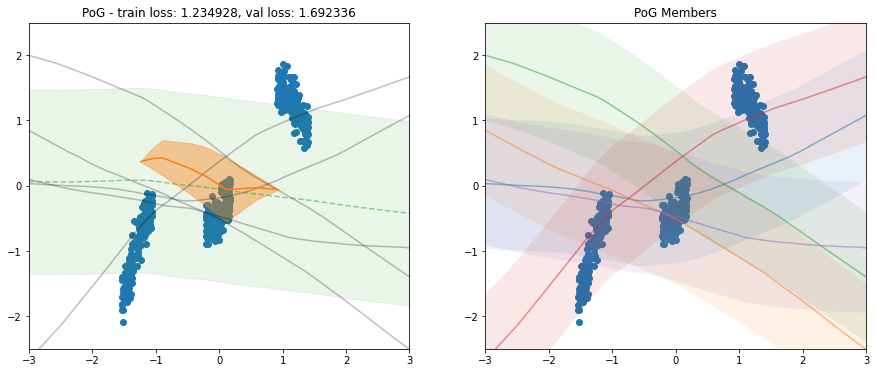

epoch:   2 - train loss: 1.15397, val_loss: 1.81156, β: 2.2, lr: 0.00010
epoch:   3 - train loss: 1.17713, val_loss: 1.96569, β: 2.3, lr: 0.00010
epoch:   4 - train loss: 1.21247, val_loss: 2.16086, β: 2.5, lr: 0.00010
epoch:   5 - train loss: 1.25819, val_loss: 2.40415, β: 2.7, lr: 0.00010
epoch:   6 - train loss: 1.29169, val_loss: 2.70309, β: 2.8, lr: 0.00010
epoch:   7 - train loss: 1.34216, val_loss: 3.06392, β: 3.0, lr: 0.00010
epoch:   8 - train loss: 1.38224, val_loss: 3.48972, β: 3.2, lr: 0.00010
epoch:   9 - train loss: 1.39964, val_loss: 3.97826, β: 3.3, lr: 0.00010
epoch:  10 - train loss: 1.37718, val_loss: 4.51888, β: 3.5, lr: 0.00010
epoch:  11 - train loss: 1.27957, val_loss: 5.09173, β: 3.7, lr: 0.00010
epoch:  12 - train loss: 1.13170, val_loss: 5.66890, β: 3.8, lr: 0.00010
epoch:  13 - train loss: 1.05978, val_loss: 6.12376, β: 4.0, lr: 0.00010
epoch:  14 - train loss: 0.70340, val_loss: 6.49651, β: 4.2, lr: 0.00010
epoch:  15 - train loss: 0.49456, val_loss: 6.79630

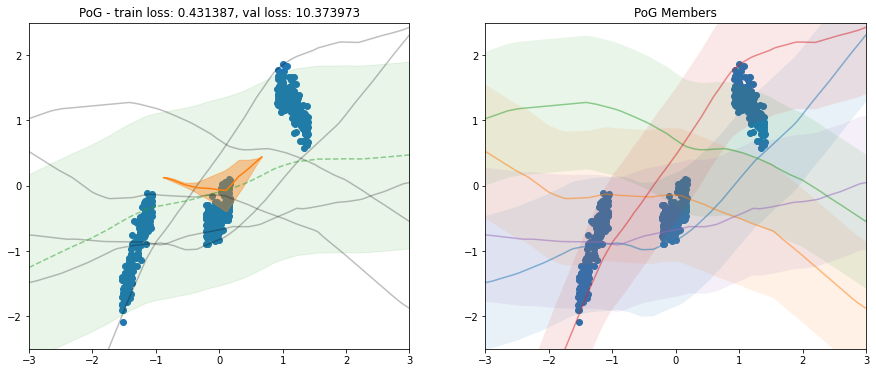

epoch:  22 - train loss: 0.19480, val_loss: 12.02707, β: 5.5, lr: 0.00010
epoch:  23 - train loss: -0.00620, val_loss: 14.05990, β: 5.7, lr: 0.00010
epoch:  24 - train loss: -0.08630, val_loss: 16.24908, β: 5.8, lr: 0.00010
epoch:  25 - train loss: 0.02176, val_loss: 18.19995, β: 6.0, lr: 0.00010
epoch:  26 - train loss: 0.09296, val_loss: 19.53561, β: 6.2, lr: 0.00010
epoch:  27 - train loss: 0.00692, val_loss: 20.29786, β: 6.3, lr: 0.00010
epoch:  28 - train loss: -0.08009, val_loss: 20.65761, β: 6.5, lr: 0.00010
epoch:  29 - train loss: -0.13973, val_loss: 20.93943, β: 6.7, lr: 0.00010
epoch:  30 - train loss: -0.14232, val_loss: 21.50277, β: 6.8, lr: 0.00010
epoch:  31 - train loss: -0.13521, val_loss: 22.65993, β: 7.0, lr: 0.00010
epoch:  32 - train loss: -0.12374, val_loss: 24.81361, β: 7.2, lr: 0.00010
epoch:  33 - train loss: -0.13795, val_loss: 28.08342, β: 7.3, lr: 0.00010
epoch:  34 - train loss: -0.14108, val_loss: 33.06731, β: 7.5, lr: 0.00010
epoch:  35 - train loss: -0.1

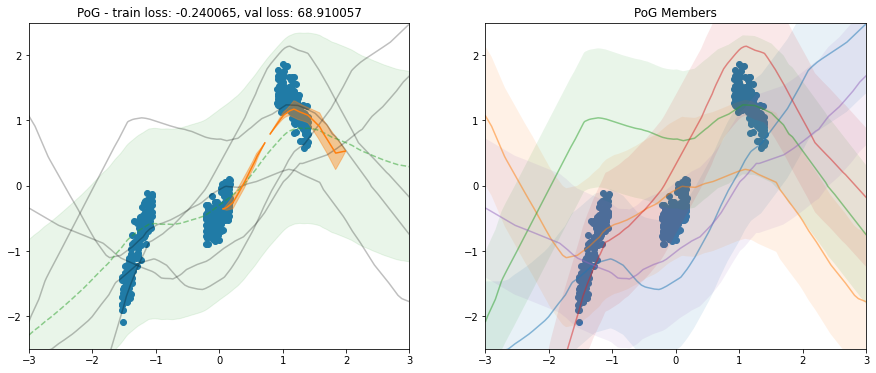

epoch:  42 - train loss: -0.26152, val_loss: 55.62929, β: 8.8, lr: 0.00010
epoch:  43 - train loss: -0.26812, val_loss: 44.01497, β: 9.0, lr: 0.00010
epoch:  44 - train loss: -0.26688, val_loss: 34.18309, β: 9.2, lr: 0.00010
epoch:  45 - train loss: -0.26742, val_loss: 27.03310, β: 9.3, lr: 0.00010
epoch:  46 - train loss: -0.26172, val_loss: 22.42706, β: 9.5, lr: 0.00010
epoch:  47 - train loss: -0.26221, val_loss: 19.51499, β: 9.7, lr: 0.00010
epoch:  48 - train loss: -0.26963, val_loss: 17.80040, β: 9.8, lr: 0.00010
epoch:  49 - train loss: -0.26793, val_loss: 16.87619, β: 10.0, lr: 0.00010
epoch:  50 - train loss: -0.27632, val_loss: 16.35906, β: 10.2, lr: 0.00010
epoch:  51 - train loss: -0.27872, val_loss: 16.00095, β: 10.3, lr: 0.00010
epoch:  52 - train loss: -0.28450, val_loss: 15.59203, β: 10.5, lr: 0.00010
epoch:  53 - train loss: -0.28689, val_loss: 14.83813, β: 10.7, lr: 0.00010
epoch:  54 - train loss: -0.28384, val_loss: 13.61594, β: 10.8, lr: 0.00010
epoch:  55 - train 

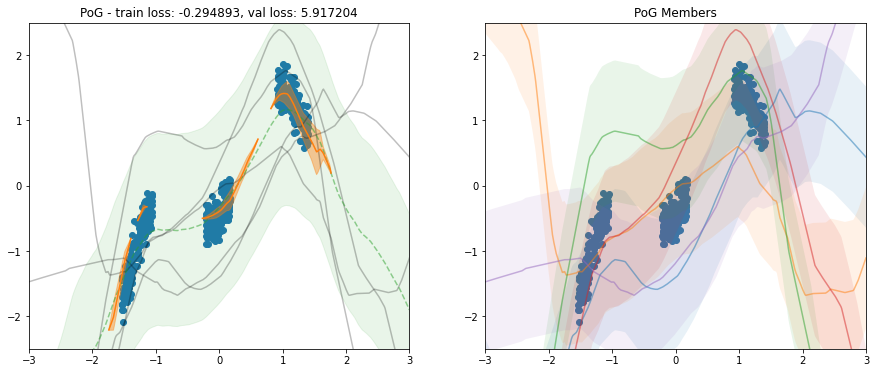

epoch:  62 - train loss: -0.29755, val_loss: 4.86423, β: 12.2, lr: 0.00010
epoch:  63 - train loss: -0.29011, val_loss: 3.84991, β: 12.3, lr: 0.00010
epoch:  64 - train loss: -0.29288, val_loss: 2.93570, β: 12.5, lr: 0.00010
epoch:  65 - train loss: -0.28875, val_loss: 2.19295, β: 12.7, lr: 0.00010
epoch:  66 - train loss: -0.29638, val_loss: 1.65437, β: 12.8, lr: 0.00010
epoch:  67 - train loss: -0.30849, val_loss: 1.31026, β: 13.0, lr: 0.00010
epoch:  68 - train loss: -0.30499, val_loss: 1.09984, β: 13.2, lr: 0.00010
epoch:  69 - train loss: -0.30356, val_loss: 0.91110, β: 13.3, lr: 0.00010
epoch:  70 - train loss: -0.29372, val_loss: 0.78409, β: 13.5, lr: 0.00010
epoch:  71 - train loss: -0.30152, val_loss: 0.68622, β: 13.7, lr: 0.00010
epoch:  72 - train loss: -0.30186, val_loss: 0.61469, β: 13.8, lr: 0.00010
epoch:  73 - train loss: -0.30143, val_loss: 0.55359, β: 14.0, lr: 0.00010
epoch:  74 - train loss: -0.30768, val_loss: 0.50102, β: 14.2, lr: 0.00010
epoch:  75 - train loss: 

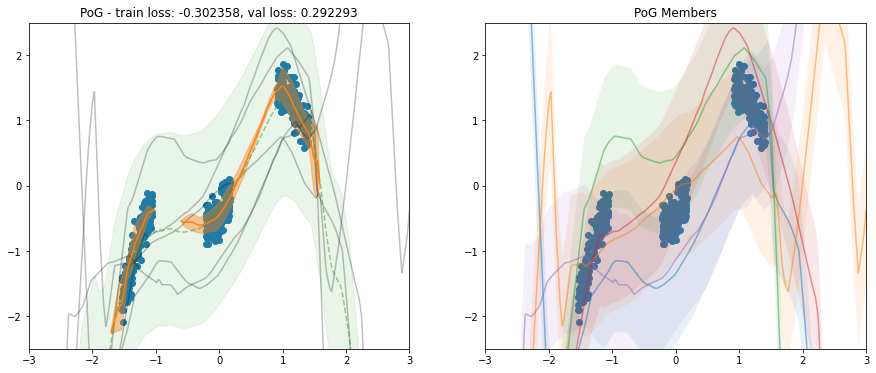

epoch:  82 - train loss: -0.30427, val_loss: 0.27895, β: 15.5, lr: 0.00010
epoch:  83 - train loss: -0.31365, val_loss: 0.27163, β: 15.7, lr: 0.00010
epoch:  84 - train loss: -0.31103, val_loss: 0.26574, β: 15.8, lr: 0.00010
epoch:  85 - train loss: -0.30870, val_loss: 0.27307, β: 16.0, lr: 0.00010
epoch:  86 - train loss: -0.31299, val_loss: 0.27672, β: 16.2, lr: 0.00010
epoch:  87 - train loss: -0.31384, val_loss: 0.28768, β: 16.3, lr: 0.00010
epoch:  88 - train loss: -0.30738, val_loss: 0.29823, β: 16.5, lr: 0.00010
epoch:  89 - train loss: -0.30934, val_loss: 0.30197, β: 16.7, lr: 0.00010
epoch:  90 - train loss: -0.30876, val_loss: 0.31791, β: 16.8, lr: 0.00010
epoch:  91 - train loss: -0.31184, val_loss: 0.33180, β: 17.0, lr: 0.00010
epoch:  92 - train loss: -0.31584, val_loss: 0.34401, β: 17.2, lr: 0.00010
epoch:  93 - train loss: -0.30685, val_loss: 0.35592, β: 17.3, lr: 0.00010
epoch:  94 - train loss: -0.30847, val_loss: 0.36693, β: 17.5, lr: 0.00010
epoch:  95 - train loss: 

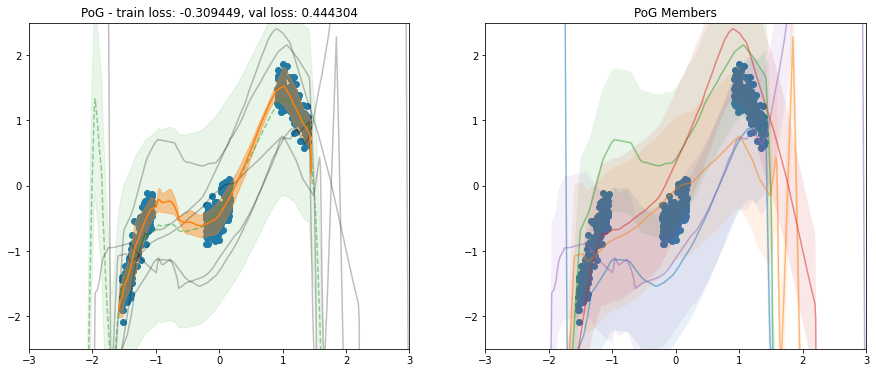

epoch: 102 - train loss: -0.31761, val_loss: 0.43565, β: 18.8, lr: 0.00010
epoch: 103 - train loss: -0.30262, val_loss: 0.41485, β: 19.0, lr: 0.00010
epoch: 104 - train loss: -0.31302, val_loss: 0.39061, β: 19.2, lr: 0.00010
epoch: 105 - train loss: -0.28306, val_loss: 0.44854, β: 19.3, lr: 0.00010
epoch: 106 - train loss: -0.30111, val_loss: 0.56348, β: 19.5, lr: 0.00010
epoch: 107 - train loss: -0.29632, val_loss: 0.70645, β: 19.7, lr: 0.00010
epoch: 108 - train loss: -0.29448, val_loss: 0.82936, β: 19.8, lr: 0.00010
epoch: 109 - train loss: -0.30054, val_loss: 0.86774, β: 20.0, lr: 0.00010
epoch: 110 - train loss: -0.29488, val_loss: 0.85540, β: 20.2, lr: 0.00010
epoch: 111 - train loss: -0.30025, val_loss: 0.82609, β: 20.3, lr: 0.00010
epoch: 112 - train loss: -0.29009, val_loss: 0.81273, β: 20.5, lr: 0.00010
epoch: 113 - train loss: -0.29118, val_loss: 0.81740, β: 20.7, lr: 0.00010
epoch: 114 - train loss: -0.29916, val_loss: 0.83466, β: 20.8, lr: 0.00010
epoch: 115 - train loss: 

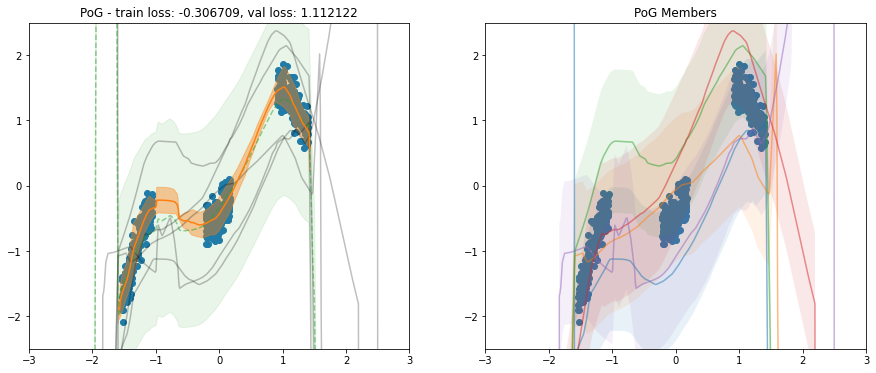

epoch: 122 - train loss: -0.30152, val_loss: 1.02035, β: 22.2, lr: 0.00010
epoch: 123 - train loss: -0.29734, val_loss: 0.94209, β: 22.3, lr: 0.00010
epoch: 124 - train loss: -0.29449, val_loss: 0.87270, β: 22.5, lr: 0.00010
epoch: 125 - train loss: -0.30257, val_loss: 0.84292, β: 22.7, lr: 0.00010
epoch: 126 - train loss: -0.28931, val_loss: 0.84233, β: 22.8, lr: 0.00010
epoch: 127 - train loss: -0.29707, val_loss: 0.84236, β: 23.0, lr: 0.00010
epoch: 128 - train loss: -0.29801, val_loss: 0.87454, β: 23.2, lr: 0.00010
epoch: 129 - train loss: -0.30090, val_loss: 0.91894, β: 23.3, lr: 0.00010
epoch: 130 - train loss: -0.29419, val_loss: 0.97920, β: 23.5, lr: 0.00010
epoch: 131 - train loss: -0.28426, val_loss: 1.08092, β: 23.7, lr: 0.00010
epoch: 132 - train loss: -0.29346, val_loss: 1.10953, β: 23.8, lr: 0.00010
epoch: 133 - train loss: -0.29519, val_loss: 1.10286, β: 24.0, lr: 0.00010
epoch: 134 - train loss: -0.28885, val_loss: 1.07934, β: 24.2, lr: 0.00010
epoch: 135 - train loss: 

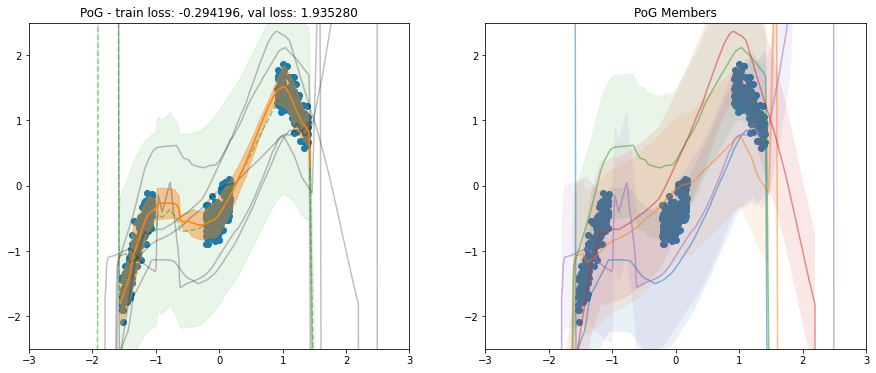

epoch: 142 - train loss: -0.29463, val_loss: 1.89763, β: 25.5, lr: 0.00010
epoch: 143 - train loss: -0.28920, val_loss: 1.74785, β: 25.7, lr: 0.00010
epoch: 144 - train loss: -0.28917, val_loss: 1.47137, β: 25.8, lr: 0.00010
epoch: 145 - train loss: -0.29245, val_loss: 1.24162, β: 26.0, lr: 0.00010
epoch: 146 - train loss: -0.28047, val_loss: 1.15395, β: 26.2, lr: 0.00010
epoch: 147 - train loss: -0.28554, val_loss: 1.23837, β: 26.3, lr: 0.00010
epoch: 148 - train loss: -0.29761, val_loss: 1.39093, β: 26.5, lr: 0.00010
epoch: 149 - train loss: -0.29205, val_loss: 1.67240, β: 26.7, lr: 0.00010
epoch: 150 - train loss: -0.29230, val_loss: 1.88465, β: 26.8, lr: 0.00010
epoch: 151 - train loss: -0.27801, val_loss: 2.01959, β: 27.0, lr: 0.00010
epoch: 152 - train loss: -0.28209, val_loss: 1.89205, β: 27.2, lr: 0.00010
epoch: 153 - train loss: -0.28269, val_loss: 1.64102, β: 27.3, lr: 0.00010
epoch: 154 - train loss: -0.28609, val_loss: 1.51665, β: 27.5, lr: 0.00010
epoch: 155 - train loss: 

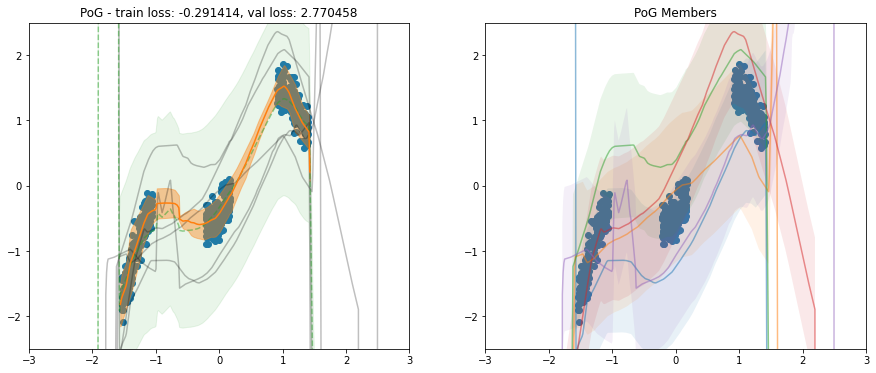

epoch: 162 - train loss: -0.28454, val_loss: 2.62633, β: 28.8, lr: 0.00010
epoch: 163 - train loss: -0.26929, val_loss: 2.79236, β: 29.0, lr: 0.00010
epoch: 164 - train loss: -0.27823, val_loss: 2.91451, β: 29.2, lr: 0.00010
epoch: 165 - train loss: -0.27730, val_loss: 3.46253, β: 29.3, lr: 0.00010
epoch: 166 - train loss: -0.28781, val_loss: 3.77902, β: 29.5, lr: 0.00010
epoch: 167 - train loss: -0.29155, val_loss: 3.88869, β: 29.7, lr: 0.00010
epoch: 168 - train loss: -0.23125, val_loss: 3.95449, β: 29.8, lr: 0.00010
epoch: 169 - train loss: -0.28024, val_loss: 3.91850, β: 30.0, lr: 0.00010
epoch: 170 - train loss: -0.25806, val_loss: 3.69904, β: 30.2, lr: 0.00010
epoch: 171 - train loss: -0.25281, val_loss: 3.51476, β: 30.3, lr: 0.00010
epoch: 172 - train loss: -0.22032, val_loss: 3.91463, β: 30.5, lr: 0.00010
Best val_loss
epoch: 173 - train loss: -0.25572, val_loss: 4.51984, β: 30.7, lr: 0.00010
epoch: 174 - train loss: -0.26441, val_loss: 4.73018, β: 30.8, lr: 0.00010
epoch: 175 

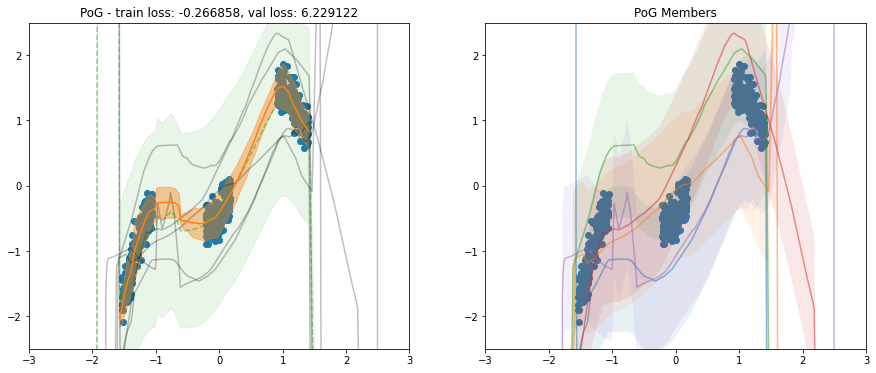

epoch: 182 - train loss: -0.26338, val_loss: 6.39799, β: 32.0, lr: 0.00010
epoch: 183 - train loss: -0.27468, val_loss: 6.04524, β: 32.0, lr: 0.00010
epoch: 184 - train loss: -0.26992, val_loss: 4.93261, β: 32.0, lr: 0.00010
epoch: 185 - train loss: -0.28311, val_loss: 3.89491, β: 32.0, lr: 0.00010
Best val_loss
epoch: 186 - train loss: -0.27233, val_loss: 3.33129, β: 32.0, lr: 0.00010
Best val_loss
epoch: 187 - train loss: -0.26327, val_loss: 3.17492, β: 32.0, lr: 0.00010
Best val_loss
epoch: 188 - train loss: -0.25956, val_loss: 3.57075, β: 32.0, lr: 0.00010
epoch: 189 - train loss: -0.27633, val_loss: 4.08243, β: 32.0, lr: 0.00010
epoch: 190 - train loss: -0.28700, val_loss: 4.15046, β: 32.0, lr: 0.00010
epoch: 191 - train loss: -0.29317, val_loss: 3.73266, β: 32.0, lr: 0.00010
epoch: 192 - train loss: -0.28615, val_loss: 3.36989, β: 32.0, lr: 0.00010
epoch: 193 - train loss: -0.17012, val_loss: 3.09781, β: 32.0, lr: 0.00010
Best val_loss
epoch: 194 - train loss: -0.23770, val_loss:

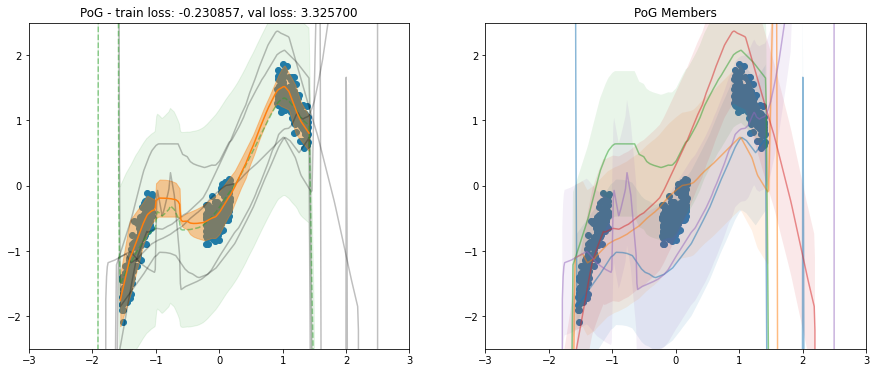

+---------------------------------------------+----------+-------+----------+--------+
| Name                                        | Shape    | Size  | Mean     | Std    |
+---------------------------------------------+----------+-------+----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0      | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0      | 0.0    |
| batch_stats/nets_2/layer_0/BatchNorm_0/me

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 1.25157, val_loss: 1.29436, β: 2.0, lr: 0.00010


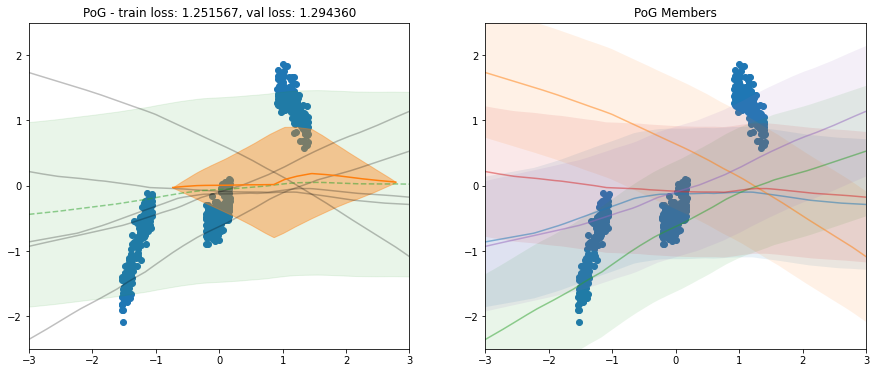

epoch:   2 - train loss: 1.23288, val_loss: 1.34463, β: 2.2, lr: 0.00010
epoch:   3 - train loss: 1.24016, val_loss: 1.41609, β: 2.3, lr: 0.00010
epoch:   4 - train loss: 1.27421, val_loss: 1.51280, β: 2.5, lr: 0.00010
epoch:   5 - train loss: 1.31516, val_loss: 1.64000, β: 2.7, lr: 0.00010
epoch:   6 - train loss: 1.36751, val_loss: 1.80317, β: 2.8, lr: 0.00010
epoch:   7 - train loss: 1.43837, val_loss: 2.00804, β: 3.0, lr: 0.00010
epoch:   8 - train loss: 1.42232, val_loss: 2.25838, β: 3.2, lr: 0.00010
epoch:   9 - train loss: 1.46566, val_loss: 2.56378, β: 3.3, lr: 0.00010
epoch:  10 - train loss: 1.53116, val_loss: 2.92816, β: 3.5, lr: 0.00010
epoch:  11 - train loss: 1.57839, val_loss: 3.35175, β: 3.7, lr: 0.00010
epoch:  12 - train loss: 1.60063, val_loss: 3.83284, β: 3.8, lr: 0.00010
epoch:  13 - train loss: 1.59754, val_loss: 4.36668, β: 4.0, lr: 0.00010
epoch:  14 - train loss: 1.56185, val_loss: 4.95763, β: 4.2, lr: 0.00010
epoch:  15 - train loss: 1.54335, val_loss: 5.61909

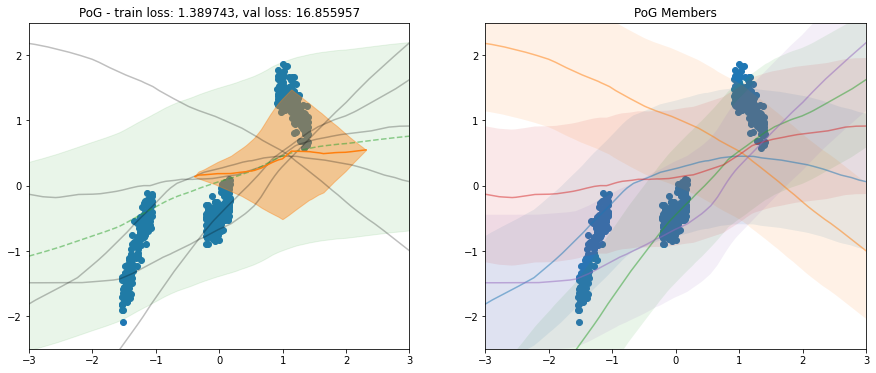

epoch:  22 - train loss: 1.17144, val_loss: 21.57018, β: 5.5, lr: 0.00010
epoch:  23 - train loss: 1.13305, val_loss: 25.99339, β: 5.7, lr: 0.00010
epoch:  24 - train loss: 1.22596, val_loss: 28.38508, β: 5.8, lr: 0.00010
epoch:  25 - train loss: 1.13485, val_loss: 28.74703, β: 6.0, lr: 0.00010
epoch:  26 - train loss: 0.84019, val_loss: 28.00114, β: 6.2, lr: 0.00010
epoch:  27 - train loss: 0.75658, val_loss: 27.17768, β: 6.3, lr: 0.00010
epoch:  28 - train loss: 0.61906, val_loss: 25.33198, β: 6.5, lr: 0.00010
epoch:  29 - train loss: 0.55248, val_loss: 24.17060, β: 6.7, lr: 0.00010
epoch:  30 - train loss: 0.47522, val_loss: 23.53601, β: 6.8, lr: 0.00010
epoch:  31 - train loss: 0.32015, val_loss: 22.98172, β: 7.0, lr: 0.00010
epoch:  32 - train loss: 0.27261, val_loss: 22.89873, β: 7.2, lr: 0.00010
epoch:  33 - train loss: 0.28342, val_loss: 23.60905, β: 7.3, lr: 0.00010
epoch:  34 - train loss: 0.18439, val_loss: 24.81070, β: 7.5, lr: 0.00010
epoch:  35 - train loss: 0.14469, val_

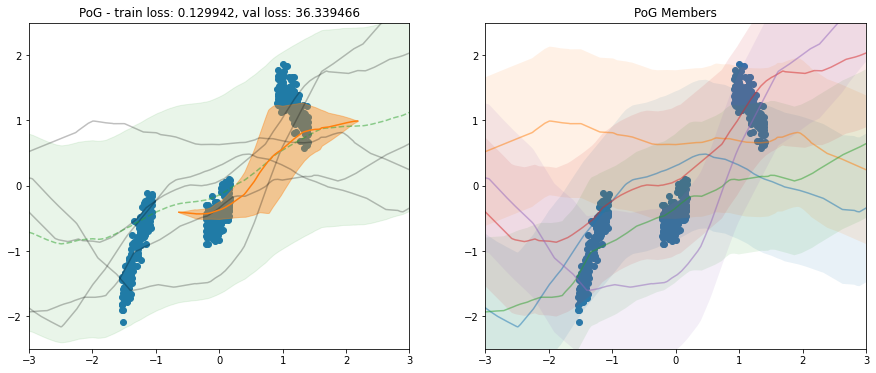

epoch:  42 - train loss: 0.01030, val_loss: 38.64507, β: 8.8, lr: 0.00010
epoch:  43 - train loss: -0.00076, val_loss: 41.16128, β: 9.0, lr: 0.00010
epoch:  44 - train loss: -0.00441, val_loss: 43.91507, β: 9.2, lr: 0.00010
epoch:  45 - train loss: -0.01572, val_loss: 47.08307, β: 9.3, lr: 0.00010
epoch:  46 - train loss: -0.00403, val_loss: 50.69395, β: 9.5, lr: 0.00010
epoch:  47 - train loss: -0.01827, val_loss: 54.83206, β: 9.7, lr: 0.00010
epoch:  48 - train loss: -0.03006, val_loss: 59.50388, β: 9.8, lr: 0.00010
epoch:  49 - train loss: -0.04149, val_loss: 64.82631, β: 10.0, lr: 0.00010
epoch:  50 - train loss: -0.05099, val_loss: 70.72861, β: 10.2, lr: 0.00010
epoch:  51 - train loss: -0.05820, val_loss: 77.16162, β: 10.3, lr: 0.00010
epoch:  52 - train loss: -0.06526, val_loss: 84.04585, β: 10.5, lr: 0.00010
epoch:  53 - train loss: -0.07547, val_loss: 91.39312, β: 10.7, lr: 0.00010
epoch:  54 - train loss: -0.08713, val_loss: 98.17673, β: 10.8, lr: 0.00010
epoch:  55 - train l

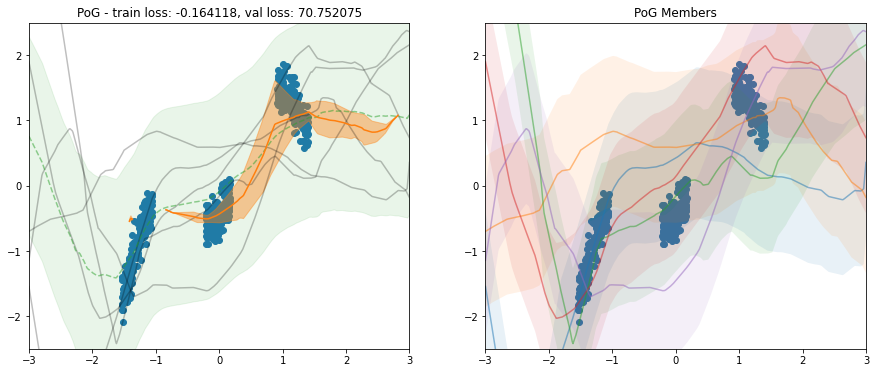

epoch:  62 - train loss: -0.17167, val_loss: 63.61956, β: 12.2, lr: 0.00010
epoch:  63 - train loss: -0.17954, val_loss: 58.03312, β: 12.3, lr: 0.00010
epoch:  64 - train loss: -0.18560, val_loss: 53.71205, β: 12.5, lr: 0.00010
epoch:  65 - train loss: -0.18919, val_loss: 50.73098, β: 12.7, lr: 0.00010
epoch:  66 - train loss: -0.20932, val_loss: 50.05690, β: 12.8, lr: 0.00010
epoch:  67 - train loss: -0.20818, val_loss: 47.51062, β: 13.0, lr: 0.00010
epoch:  68 - train loss: -0.21805, val_loss: 41.42954, β: 13.2, lr: 0.00010
epoch:  69 - train loss: -0.22690, val_loss: 30.78318, β: 13.3, lr: 0.00010
epoch:  70 - train loss: -0.22309, val_loss: 17.85872, β: 13.5, lr: 0.00010
epoch:  71 - train loss: -0.22510, val_loss: 8.92762, β: 13.7, lr: 0.00010
epoch:  72 - train loss: -0.23966, val_loss: 4.11867, β: 13.8, lr: 0.00010
epoch:  73 - train loss: -0.23741, val_loss: 1.91132, β: 14.0, lr: 0.00010
epoch:  74 - train loss: -0.23915, val_loss: 0.96075, β: 14.2, lr: 0.00010
epoch:  75 - tra

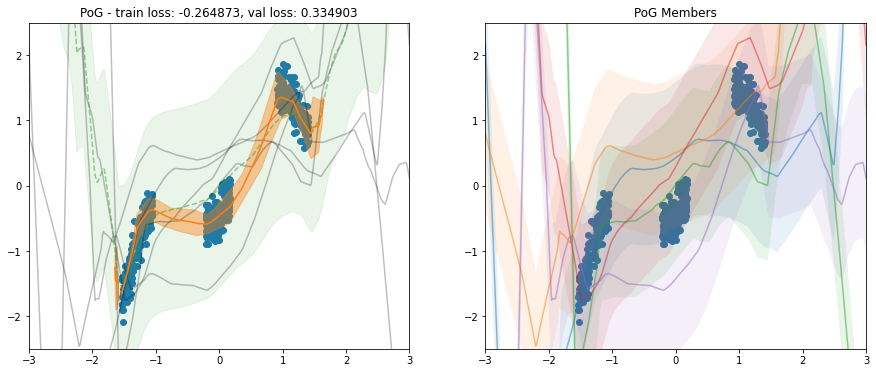

epoch:  82 - train loss: -0.26391, val_loss: 0.19695, β: 15.5, lr: 0.00010
epoch:  83 - train loss: -0.26783, val_loss: 0.07002, β: 15.7, lr: 0.00010
epoch:  84 - train loss: -0.27232, val_loss: -0.02992, β: 15.8, lr: 0.00010
epoch:  85 - train loss: -0.27912, val_loss: -0.09080, β: 16.0, lr: 0.00010
epoch:  86 - train loss: -0.28446, val_loss: -0.11266, β: 16.2, lr: 0.00010
epoch:  87 - train loss: -0.28551, val_loss: -0.12056, β: 16.3, lr: 0.00010
epoch:  88 - train loss: -0.27991, val_loss: -0.12389, β: 16.5, lr: 0.00010
epoch:  89 - train loss: -0.28888, val_loss: -0.12452, β: 16.7, lr: 0.00010
epoch:  90 - train loss: -0.28457, val_loss: -0.12298, β: 16.8, lr: 0.00010
epoch:  91 - train loss: -0.28460, val_loss: -0.12038, β: 17.0, lr: 0.00010
epoch:  92 - train loss: -0.28616, val_loss: -0.11798, β: 17.2, lr: 0.00010
epoch:  93 - train loss: -0.29084, val_loss: -0.11545, β: 17.3, lr: 0.00010
epoch:  94 - train loss: -0.28801, val_loss: -0.11241, β: 17.5, lr: 0.00010
epoch:  95 - t

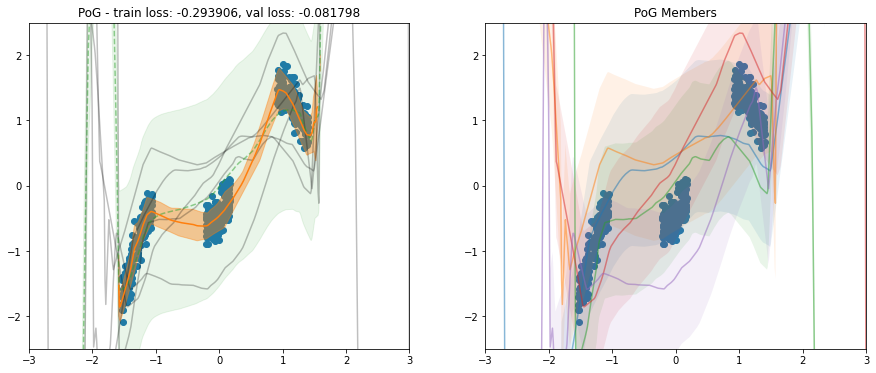

epoch: 102 - train loss: -0.29028, val_loss: -0.07914, β: 18.8, lr: 0.00010
epoch: 103 - train loss: -0.29839, val_loss: -0.07778, β: 19.0, lr: 0.00010
epoch: 104 - train loss: -0.29310, val_loss: -0.07472, β: 19.2, lr: 0.00010
epoch: 105 - train loss: -0.29475, val_loss: -0.06743, β: 19.3, lr: 0.00010
epoch: 106 - train loss: -0.29679, val_loss: -0.05523, β: 19.5, lr: 0.00010
epoch: 107 - train loss: -0.29711, val_loss: -0.04428, β: 19.7, lr: 0.00010
epoch: 108 - train loss: -0.29687, val_loss: -0.03110, β: 19.8, lr: 0.00010
epoch: 109 - train loss: -0.29169, val_loss: -0.01736, β: 20.0, lr: 0.00010
epoch: 110 - train loss: -0.29757, val_loss: -0.00688, β: 20.2, lr: 0.00010
epoch: 111 - train loss: -0.29118, val_loss: 0.00617, β: 20.3, lr: 0.00010
epoch: 112 - train loss: -0.28857, val_loss: 0.02606, β: 20.5, lr: 0.00010
epoch: 113 - train loss: -0.29088, val_loss: 0.05102, β: 20.7, lr: 0.00010
epoch: 114 - train loss: -0.29664, val_loss: 0.06387, β: 20.8, lr: 0.00010
epoch: 115 - tra

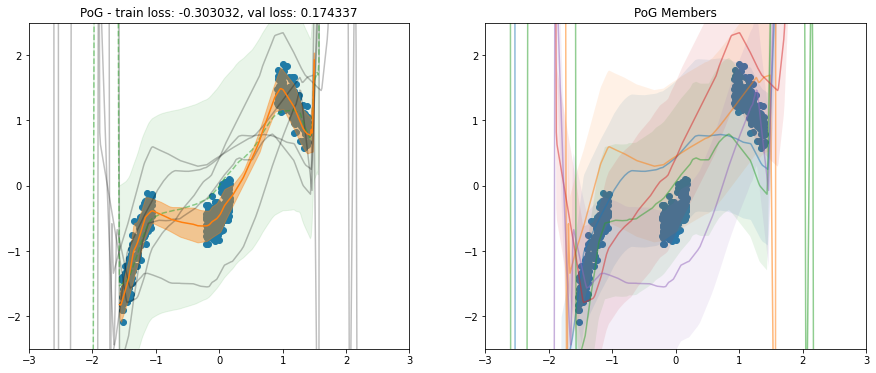

epoch: 122 - train loss: -0.29753, val_loss: 0.18353, β: 22.2, lr: 0.00010
epoch: 123 - train loss: -0.29573, val_loss: 0.21463, β: 22.3, lr: 0.00010
epoch: 124 - train loss: -0.29885, val_loss: 0.25135, β: 22.5, lr: 0.00010
epoch: 125 - train loss: -0.30127, val_loss: 0.28753, β: 22.7, lr: 0.00010
epoch: 126 - train loss: -0.29292, val_loss: 0.31203, β: 22.8, lr: 0.00010
epoch: 127 - train loss: -0.28578, val_loss: 0.33612, β: 23.0, lr: 0.00010
epoch: 128 - train loss: -0.29327, val_loss: 0.36537, β: 23.2, lr: 0.00010
epoch: 129 - train loss: -0.29754, val_loss: 0.40249, β: 23.3, lr: 0.00010
epoch: 130 - train loss: -0.29752, val_loss: 0.45087, β: 23.5, lr: 0.00010
epoch: 131 - train loss: -0.29211, val_loss: 0.52027, β: 23.7, lr: 0.00010
epoch: 132 - train loss: -0.29176, val_loss: 0.59344, β: 23.8, lr: 0.00010
epoch: 133 - train loss: -0.29242, val_loss: 0.63507, β: 24.0, lr: 0.00010
epoch: 134 - train loss: -0.29371, val_loss: 0.64392, β: 24.2, lr: 0.00010
epoch: 135 - train loss: 

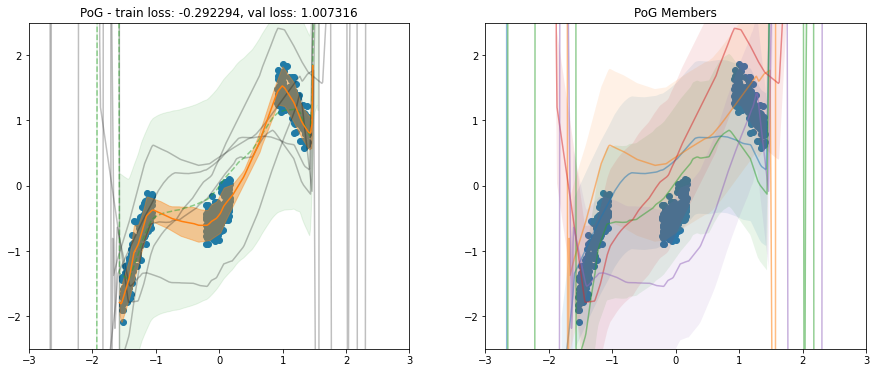

epoch: 142 - train loss: -0.30178, val_loss: 0.96808, β: 25.5, lr: 0.00010
epoch: 143 - train loss: -0.30208, val_loss: 0.90902, β: 25.7, lr: 0.00010
epoch: 144 - train loss: -0.29494, val_loss: 0.82018, β: 25.8, lr: 0.00010
epoch: 145 - train loss: -0.29763, val_loss: 0.79217, β: 26.0, lr: 0.00010
epoch: 146 - train loss: -0.28833, val_loss: 0.83711, β: 26.2, lr: 0.00010
epoch: 147 - train loss: -0.29849, val_loss: 0.94874, β: 26.3, lr: 0.00010
epoch: 148 - train loss: -0.29828, val_loss: 1.04193, β: 26.5, lr: 0.00010
epoch: 149 - train loss: -0.28664, val_loss: 1.13523, β: 26.7, lr: 0.00010
epoch: 150 - train loss: -0.29775, val_loss: 1.23418, β: 26.8, lr: 0.00010
epoch: 151 - train loss: -0.29647, val_loss: 1.33994, β: 27.0, lr: 0.00010
epoch: 152 - train loss: -0.29581, val_loss: 1.41504, β: 27.2, lr: 0.00010
epoch: 153 - train loss: -0.29820, val_loss: 1.49438, β: 27.3, lr: 0.00010
epoch: 154 - train loss: -0.29514, val_loss: 1.60932, β: 27.5, lr: 0.00010
epoch: 155 - train loss: 

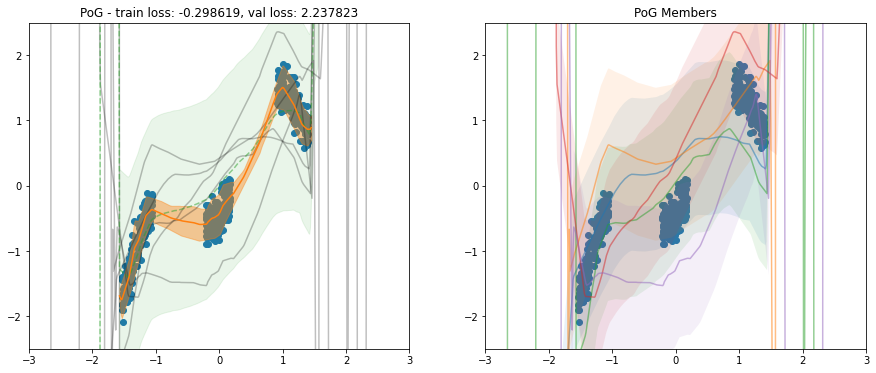

epoch: 162 - train loss: -0.28975, val_loss: 2.52411, β: 28.8, lr: 0.00010
epoch: 163 - train loss: -0.29204, val_loss: 2.82159, β: 29.0, lr: 0.00010
epoch: 164 - train loss: -0.29717, val_loss: 3.05670, β: 29.2, lr: 0.00010
epoch: 165 - train loss: -0.29049, val_loss: 3.05520, β: 29.3, lr: 0.00010
epoch: 166 - train loss: -0.29077, val_loss: 2.89094, β: 29.5, lr: 0.00010
epoch: 167 - train loss: -0.30320, val_loss: 2.77619, β: 29.7, lr: 0.00010
epoch: 168 - train loss: -0.29845, val_loss: 2.79653, β: 29.8, lr: 0.00010
epoch: 169 - train loss: -0.29249, val_loss: 2.97508, β: 30.0, lr: 0.00010
epoch: 170 - train loss: -0.28949, val_loss: 3.11120, β: 30.2, lr: 0.00010
epoch: 171 - train loss: -0.29284, val_loss: 3.13147, β: 30.3, lr: 0.00010
epoch: 172 - train loss: -0.29944, val_loss: 3.15653, β: 30.5, lr: 0.00010
Best val_loss
epoch: 173 - train loss: -0.29439, val_loss: 3.35593, β: 30.7, lr: 0.00010
epoch: 174 - train loss: -0.29200, val_loss: 3.63795, β: 30.8, lr: 0.00010
epoch: 175 

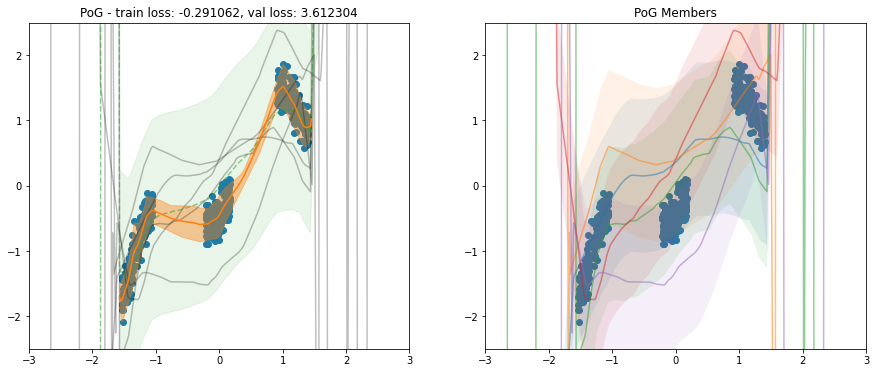

epoch: 182 - train loss: -0.30038, val_loss: 3.60628, β: 32.0, lr: 0.00010
epoch: 183 - train loss: -0.28938, val_loss: 3.84656, β: 32.0, lr: 0.00010
epoch: 184 - train loss: -0.29102, val_loss: 3.97326, β: 32.0, lr: 0.00010
epoch: 185 - train loss: -0.29234, val_loss: 3.97855, β: 32.0, lr: 0.00010
epoch: 186 - train loss: -0.29097, val_loss: 4.22387, β: 32.0, lr: 0.00010
epoch: 187 - train loss: -0.29383, val_loss: 4.24140, β: 32.0, lr: 0.00010
epoch: 188 - train loss: -0.29354, val_loss: 3.99515, β: 32.0, lr: 0.00010
epoch: 189 - train loss: -0.29876, val_loss: 3.64445, β: 32.0, lr: 0.00010
epoch: 190 - train loss: -0.29419, val_loss: 3.50746, β: 32.0, lr: 0.00010
epoch: 191 - train loss: -0.29152, val_loss: 3.47638, β: 32.0, lr: 0.00010
epoch: 192 - train loss: -0.28746, val_loss: 3.80709, β: 32.0, lr: 0.00010
epoch: 193 - train loss: -0.29436, val_loss: 4.27611, β: 32.0, lr: 0.00010
epoch: 194 - train loss: -0.28300, val_loss: 4.69104, β: 32.0, lr: 0.00010
epoch: 195 - train loss: 

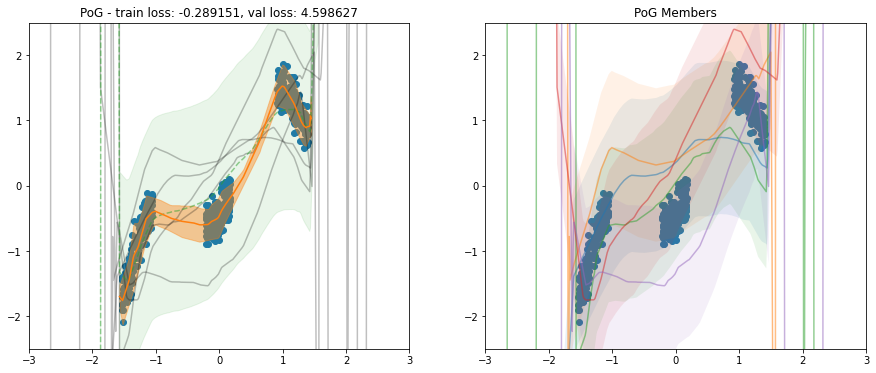

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - train loss: 2.43344, val_loss: 1.52905, β: 2.0, lr: 0.00010


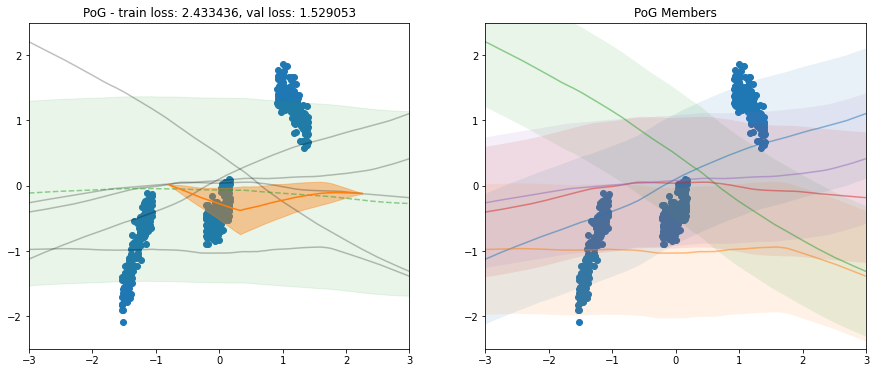

epoch:   2 - train loss: 2.28784, val_loss: 1.60654, β: 2.2, lr: 0.00010
epoch:   3 - train loss: 2.40499, val_loss: 1.70030, β: 2.3, lr: 0.00010
epoch:   4 - train loss: 2.50613, val_loss: 1.80814, β: 2.5, lr: 0.00010
epoch:   5 - train loss: 2.57527, val_loss: 1.92509, β: 2.7, lr: 0.00010
epoch:   6 - train loss: 2.59851, val_loss: 2.04703, β: 2.8, lr: 0.00010
epoch:   7 - train loss: 2.62130, val_loss: 2.16488, β: 3.0, lr: 0.00010
epoch:   8 - train loss: 2.55241, val_loss: 2.27361, β: 3.2, lr: 0.00010
epoch:   9 - train loss: 2.42979, val_loss: 2.36470, β: 3.3, lr: 0.00010
epoch:  10 - train loss: 2.16498, val_loss: 2.43707, β: 3.5, lr: 0.00010
epoch:  11 - train loss: 1.76268, val_loss: 2.49245, β: 3.7, lr: 0.00010
epoch:  12 - train loss: 1.51771, val_loss: 2.52600, β: 3.8, lr: 0.00010
epoch:  13 - train loss: 1.29348, val_loss: 2.53698, β: 4.0, lr: 0.00010
epoch:  14 - train loss: 1.07631, val_loss: 2.52718, β: 4.2, lr: 0.00010
epoch:  15 - train loss: 0.86528, val_loss: 2.50037

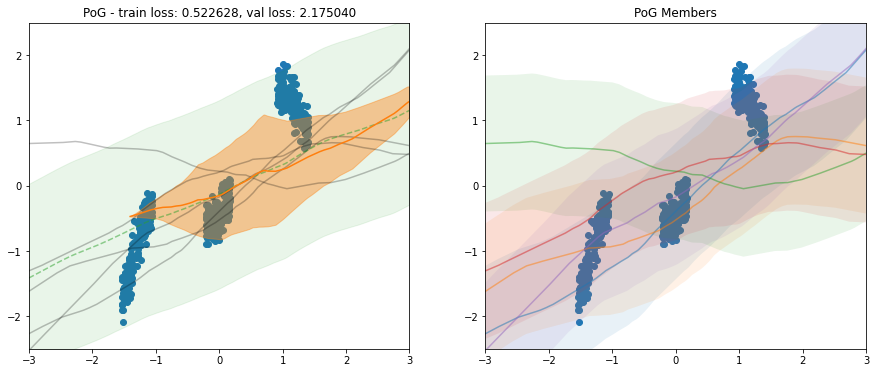

epoch:  22 - train loss: 0.52322, val_loss: 2.15495, β: 5.5, lr: 0.00010
epoch:  23 - train loss: 0.50654, val_loss: 2.16728, β: 5.7, lr: 0.00010
epoch:  24 - train loss: 0.47206, val_loss: 2.20901, β: 5.8, lr: 0.00010
epoch:  25 - train loss: 0.42435, val_loss: 2.27509, β: 6.0, lr: 0.00010
epoch:  26 - train loss: 0.38685, val_loss: 2.35765, β: 6.2, lr: 0.00010
epoch:  27 - train loss: 0.37124, val_loss: 2.44826, β: 6.3, lr: 0.00010
epoch:  28 - train loss: 0.35854, val_loss: 2.53459, β: 6.5, lr: 0.00010
epoch:  29 - train loss: 0.38036, val_loss: 2.60973, β: 6.7, lr: 0.00010
epoch:  30 - train loss: 0.38788, val_loss: 2.67545, β: 6.8, lr: 0.00010
epoch:  31 - train loss: 0.34567, val_loss: 2.74531, β: 7.0, lr: 0.00010
epoch:  32 - train loss: 0.31694, val_loss: 2.81216, β: 7.2, lr: 0.00010
epoch:  33 - train loss: 0.28837, val_loss: 2.89776, β: 7.3, lr: 0.00010
epoch:  34 - train loss: 0.25983, val_loss: 3.00178, β: 7.5, lr: 0.00010
epoch:  35 - train loss: 0.23630, val_loss: 3.12958

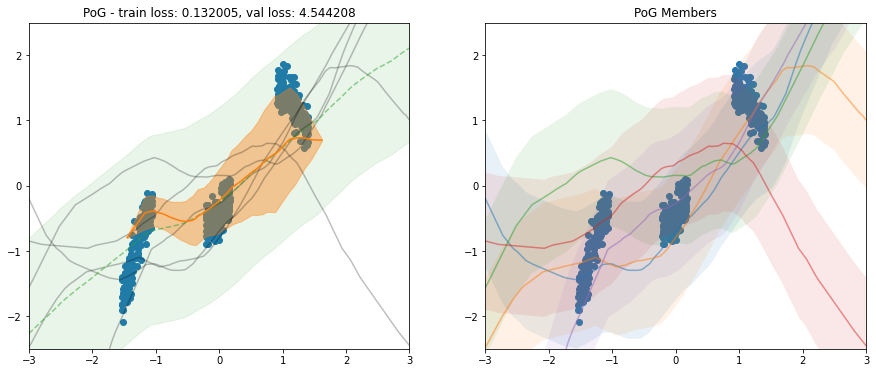

epoch:  42 - train loss: 0.11678, val_loss: 4.94319, β: 8.8, lr: 0.00010
epoch:  43 - train loss: 0.10084, val_loss: 5.49777, β: 9.0, lr: 0.00010
epoch:  44 - train loss: 0.08357, val_loss: 6.28896, β: 9.2, lr: 0.00010
epoch:  45 - train loss: 0.06520, val_loss: 7.43788, β: 9.3, lr: 0.00010
epoch:  46 - train loss: 0.04307, val_loss: 9.17350, β: 9.5, lr: 0.00010
epoch:  47 - train loss: 0.02540, val_loss: 11.93638, β: 9.7, lr: 0.00010
epoch:  48 - train loss: -0.00094, val_loss: 16.42885, β: 9.8, lr: 0.00010
epoch:  49 - train loss: -0.01967, val_loss: 23.07268, β: 10.0, lr: 0.00010
epoch:  50 - train loss: -0.03064, val_loss: 32.63288, β: 10.2, lr: 0.00010
epoch:  51 - train loss: -0.02645, val_loss: 24.40061, β: 10.3, lr: 0.00010
epoch:  52 - train loss: -0.06267, val_loss: 15.74769, β: 10.5, lr: 0.00010
epoch:  53 - train loss: -0.08214, val_loss: 10.33244, β: 10.7, lr: 0.00010
epoch:  54 - train loss: -0.08591, val_loss: 7.27525, β: 10.8, lr: 0.00010
epoch:  55 - train loss: -0.094

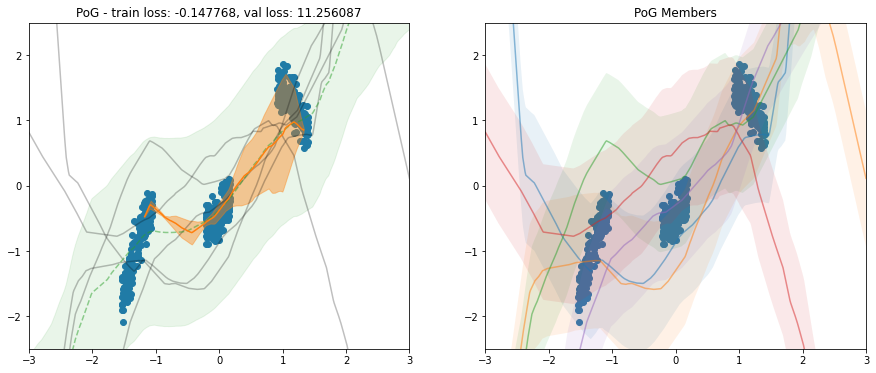

epoch:  62 - train loss: -0.13634, val_loss: 6.50095, β: 12.2, lr: 0.00010
epoch:  63 - train loss: -0.14764, val_loss: 3.39245, β: 12.3, lr: 0.00010
epoch:  64 - train loss: -0.15946, val_loss: 2.28100, β: 12.5, lr: 0.00010
epoch:  65 - train loss: -0.15152, val_loss: 1.90535, β: 12.7, lr: 0.00010
epoch:  66 - train loss: -0.15755, val_loss: 1.90083, β: 12.8, lr: 0.00010
epoch:  67 - train loss: -0.16388, val_loss: 2.06281, β: 13.0, lr: 0.00010
epoch:  68 - train loss: -0.16399, val_loss: 2.40184, β: 13.2, lr: 0.00010
epoch:  69 - train loss: -0.17578, val_loss: 3.05887, β: 13.3, lr: 0.00010
epoch:  70 - train loss: -0.18594, val_loss: 4.04292, β: 13.5, lr: 0.00010
epoch:  71 - train loss: -0.18342, val_loss: 4.63319, β: 13.7, lr: 0.00010
epoch:  72 - train loss: -0.17881, val_loss: 4.54702, β: 13.8, lr: 0.00010
epoch:  73 - train loss: -0.19240, val_loss: 4.97591, β: 14.0, lr: 0.00010
epoch:  74 - train loss: -0.18888, val_loss: 5.19585, β: 14.2, lr: 0.00010
epoch:  75 - train loss: 

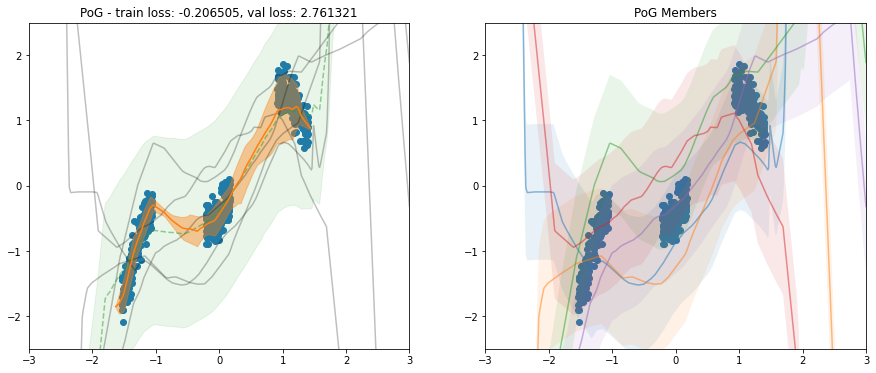

epoch:  82 - train loss: -0.21238, val_loss: 3.31566, β: 15.5, lr: 0.00010
epoch:  83 - train loss: -0.21388, val_loss: 4.03133, β: 15.7, lr: 0.00010
epoch:  84 - train loss: -0.21129, val_loss: 4.51608, β: 15.8, lr: 0.00010
epoch:  85 - train loss: -0.21936, val_loss: 4.62711, β: 16.0, lr: 0.00010
epoch:  86 - train loss: -0.21544, val_loss: 4.42463, β: 16.2, lr: 0.00010
epoch:  87 - train loss: -0.22487, val_loss: 4.06601, β: 16.3, lr: 0.00010
epoch:  88 - train loss: -0.22044, val_loss: 4.02126, β: 16.5, lr: 0.00010
epoch:  89 - train loss: -0.22577, val_loss: 4.16404, β: 16.7, lr: 0.00010
epoch:  90 - train loss: -0.22656, val_loss: 4.15565, β: 16.8, lr: 0.00010
epoch:  91 - train loss: -0.23068, val_loss: 4.00927, β: 17.0, lr: 0.00010
epoch:  92 - train loss: -0.23473, val_loss: 3.69085, β: 17.2, lr: 0.00010
epoch:  93 - train loss: -0.23728, val_loss: 3.36413, β: 17.3, lr: 0.00010
epoch:  94 - train loss: -0.23561, val_loss: 3.24940, β: 17.5, lr: 0.00010
epoch:  95 - train loss: 

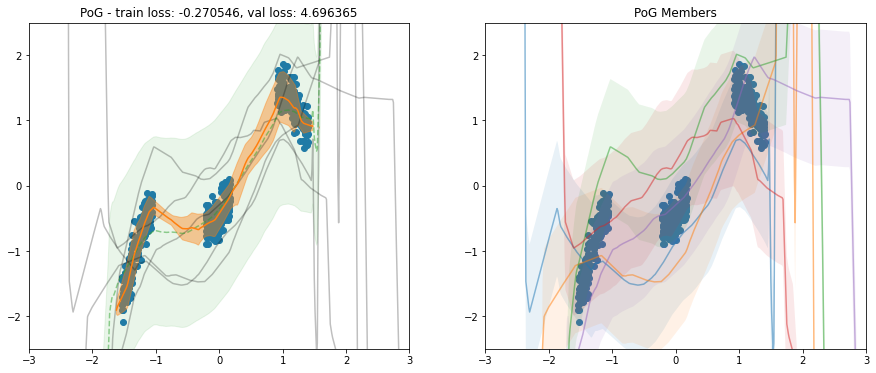

epoch: 102 - train loss: -0.27183, val_loss: 4.70297, β: 18.8, lr: 0.00010
epoch: 103 - train loss: -0.27000, val_loss: 5.44933, β: 19.0, lr: 0.00010
epoch: 104 - train loss: -0.27747, val_loss: 6.05764, β: 19.2, lr: 0.00010
epoch: 105 - train loss: -0.28982, val_loss: 5.17283, β: 19.3, lr: 0.00010
epoch: 106 - train loss: -0.29139, val_loss: 3.58866, β: 19.5, lr: 0.00010
epoch: 107 - train loss: -0.29197, val_loss: 2.70935, β: 19.7, lr: 0.00010
epoch: 108 - train loss: -0.29752, val_loss: 2.59780, β: 19.8, lr: 0.00010
epoch: 109 - train loss: -0.29192, val_loss: 2.55479, β: 20.0, lr: 0.00010
epoch: 110 - train loss: -0.29428, val_loss: 2.14822, β: 20.2, lr: 0.00010
epoch: 111 - train loss: -0.29557, val_loss: 1.48147, β: 20.3, lr: 0.00010
epoch: 112 - train loss: -0.29867, val_loss: 1.12115, β: 20.5, lr: 0.00010
epoch: 113 - train loss: -0.29877, val_loss: 1.17328, β: 20.7, lr: 0.00010
epoch: 114 - train loss: -0.29298, val_loss: 1.22927, β: 20.8, lr: 0.00010
epoch: 115 - train loss: 

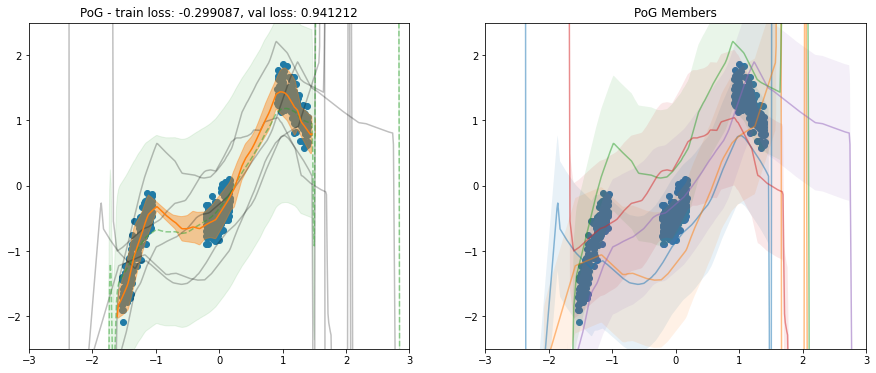

epoch: 122 - train loss: -0.29285, val_loss: 1.07277, β: 22.2, lr: 0.00010
epoch: 123 - train loss: -0.27183, val_loss: 0.78338, β: 22.3, lr: 0.00010
epoch: 124 - train loss: -0.29041, val_loss: 0.66389, β: 22.5, lr: 0.00010
epoch: 125 - train loss: -0.27897, val_loss: 0.72640, β: 22.7, lr: 0.00010
epoch: 126 - train loss: -0.28809, val_loss: 1.14644, β: 22.8, lr: 0.00010
epoch: 127 - train loss: -0.28982, val_loss: 1.58133, β: 23.0, lr: 0.00010
epoch: 128 - train loss: -0.28413, val_loss: 0.97979, β: 23.2, lr: 0.00010
epoch: 129 - train loss: -0.29307, val_loss: 0.75357, β: 23.3, lr: 0.00010
epoch: 130 - train loss: -0.28423, val_loss: 1.05422, β: 23.5, lr: 0.00010
epoch: 131 - train loss: -0.29054, val_loss: 3.09138, β: 23.7, lr: 0.00010
epoch: 132 - train loss: -0.28577, val_loss: 4.61557, β: 23.8, lr: 0.00010
epoch: 133 - train loss: -0.27475, val_loss: 1.69741, β: 24.0, lr: 0.00010
epoch: 134 - train loss: -0.28757, val_loss: 1.60008, β: 24.2, lr: 0.00010
epoch: 135 - train loss: 

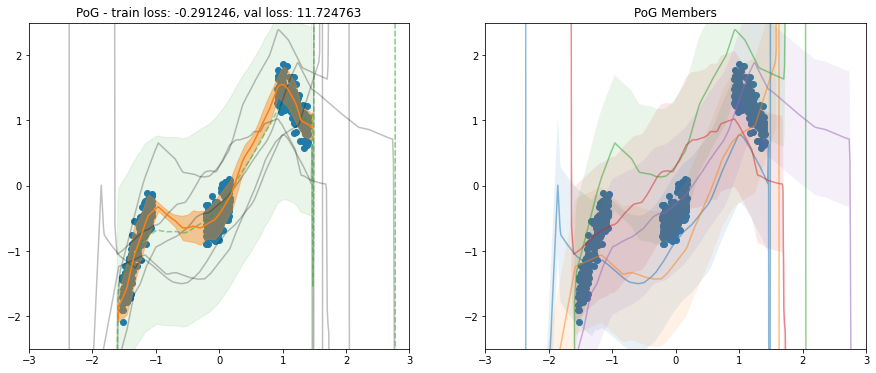

epoch: 142 - train loss: -0.27498, val_loss: 6.31147, β: 25.5, lr: 0.00010
epoch: 143 - train loss: -0.28130, val_loss: 2.55199, β: 25.7, lr: 0.00010
epoch: 144 - train loss: -0.28634, val_loss: 1.58461, β: 25.8, lr: 0.00010
epoch: 145 - train loss: -0.28508, val_loss: 2.16715, β: 26.0, lr: 0.00010
epoch: 146 - train loss: -0.28631, val_loss: 6.46137, β: 26.2, lr: 0.00010
epoch: 147 - train loss: -0.28513, val_loss: 16.54287, β: 26.3, lr: 0.00010
epoch: 148 - train loss: -0.27634, val_loss: 9.36322, β: 26.5, lr: 0.00010
epoch: 149 - train loss: -0.28494, val_loss: 2.74949, β: 26.7, lr: 0.00010
epoch: 150 - train loss: -0.28490, val_loss: 2.19750, β: 26.8, lr: 0.00010
epoch: 151 - train loss: -0.27111, val_loss: 7.11475, β: 27.0, lr: 0.00010
epoch: 152 - train loss: -0.27725, val_loss: 15.36348, β: 27.2, lr: 0.00010
epoch: 153 - train loss: -0.27657, val_loss: 7.93049, β: 27.3, lr: 0.00010
epoch: 154 - train loss: -0.26986, val_loss: 2.47869, β: 27.5, lr: 0.00010
epoch: 155 - train loss

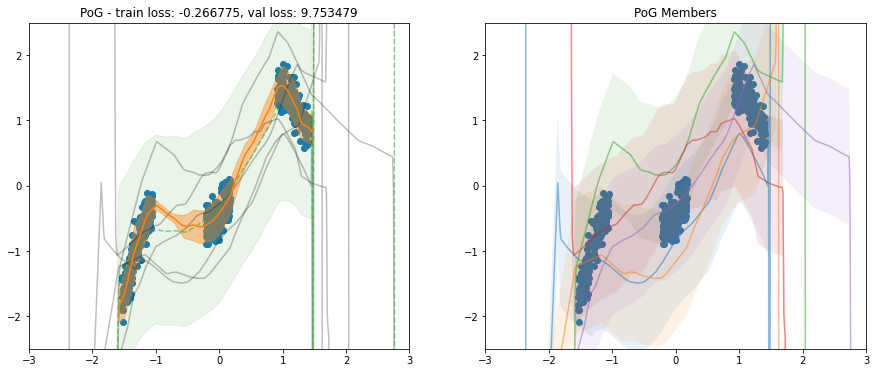

epoch: 162 - train loss: -0.27021, val_loss: 4.32383, β: 28.8, lr: 0.00010
epoch: 163 - train loss: -0.27604, val_loss: 1.94368, β: 29.0, lr: 0.00010
epoch: 164 - train loss: -0.27210, val_loss: 1.67824, β: 29.2, lr: 0.00010
epoch: 165 - train loss: -0.27242, val_loss: 2.15560, β: 29.3, lr: 0.00010
epoch: 166 - train loss: -0.27823, val_loss: 3.63653, β: 29.5, lr: 0.00010
epoch: 167 - train loss: -0.28282, val_loss: 5.75906, β: 29.7, lr: 0.00010
epoch: 168 - train loss: -0.27965, val_loss: 7.95771, β: 29.8, lr: 0.00010
epoch: 169 - train loss: -0.27474, val_loss: 5.48610, β: 30.0, lr: 0.00010
epoch: 170 - train loss: -0.27769, val_loss: 4.39148, β: 30.2, lr: 0.00010
epoch: 171 - train loss: -0.26876, val_loss: 15.19771, β: 30.3, lr: 0.00010
epoch: 172 - train loss: -0.27676, val_loss: 11.64359, β: 30.5, lr: 0.00010
Best val_loss
epoch: 173 - train loss: -0.26681, val_loss: 2.92478, β: 30.7, lr: 0.00010
Best val_loss
epoch: 174 - train loss: -0.27409, val_loss: 1.81923, β: 30.8, lr: 0.0

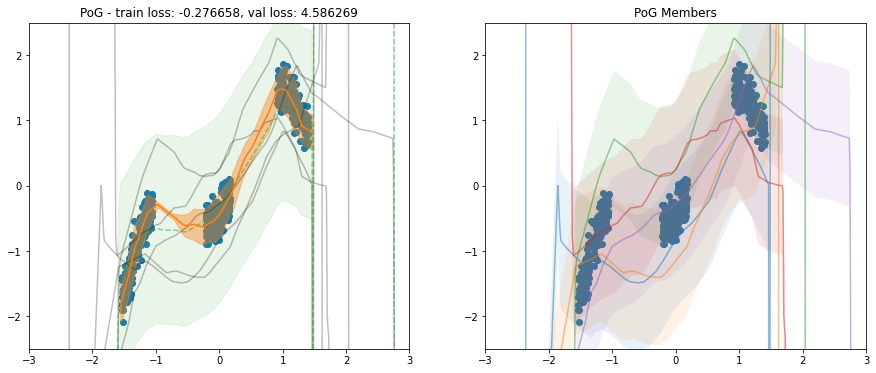

epoch: 182 - train loss: -0.27458, val_loss: 15.86883, β: 32.0, lr: 0.00010
epoch: 183 - train loss: -0.27756, val_loss: 7.68461, β: 32.0, lr: 0.00010
epoch: 184 - train loss: -0.26803, val_loss: 6.41670, β: 32.0, lr: 0.00010
epoch: 185 - train loss: -0.26864, val_loss: 4.28388, β: 32.0, lr: 0.00010
epoch: 186 - train loss: -0.27375, val_loss: 3.50668, β: 32.0, lr: 0.00010
epoch: 187 - train loss: -0.28042, val_loss: 3.59329, β: 32.0, lr: 0.00010
epoch: 188 - train loss: -0.28128, val_loss: 4.91646, β: 32.0, lr: 0.00010
epoch: 189 - train loss: -0.26935, val_loss: 9.96343, β: 32.0, lr: 0.00010
epoch: 190 - train loss: -0.27881, val_loss: 18.17762, β: 32.0, lr: 0.00010
epoch: 191 - train loss: -0.27409, val_loss: 8.78708, β: 32.0, lr: 0.00010
epoch: 192 - train loss: -0.25280, val_loss: 3.26070, β: 32.0, lr: 0.00010
epoch: 193 - train loss: -0.27029, val_loss: 3.83002, β: 32.0, lr: 0.00010
epoch: 194 - train loss: -0.26893, val_loss: 17.57624, β: 32.0, lr: 0.00010
epoch: 195 - train los

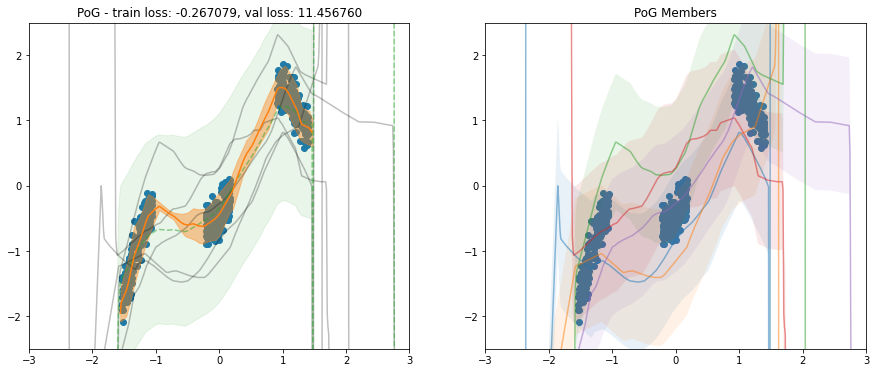

In [6]:
init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

if RETRAIN:
    best_pog_states = []
    for i in range(3):
        rng = random.PRNGKey(i)

        setup_rng, rng = random.split(rng)

        model, state = setup_training(config, setup_rng, init_x, init_y)

        state, best_state = train_loop(
            model, state, config, rng, make_PoG_Ens_loss, make_PoG_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_PoG_plots,
        )

        best_pog_states.append(best_state)

In [ ]:
if RETRAIN:
    save_checkpoint('pog_models', best_pog_states, 1)

## Paper Plots

In [27]:
restored_pog_models = restore_checkpoint('pog_models', 1)

In [121]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_3637169/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [34]:
X_test, y_test = list(zip(*test_loader.dataset))

In [50]:
def entropy(loc, scale):
    upper = loc + scale
    lower = loc - scale
    return jnp.log(upper - lower)

In [47]:
def mse(loc, y):
    return jnp.mean((loc - y)**2)

In [84]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse'])
results_df

Empty DataFrame
Columns: [model_name, n_members, random_seed, H, mse]
Index: []

In [86]:
s = set(range(5))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for i in range(3):
    state = restored_pog_models[f'{i}']
    
    pred_fun = partial(
    model.apply,
        {"params": state['params'], **state['model_state']},
        train=False, return_ens_preds=True,
        method=model.pred
    )
    _, (locs, scales) = jax.vmap(
        pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
    )(jnp.array(X_test))

    for indices in power_set:
        model_name = 'PoG'
        n_members = len(indices)

        loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])

        entropies = jax.vmap(entropy)(loc, scale)
        errors = jax.vmap(mse)(loc, jnp.array(y_test))

        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                'model_name': [model_name],
                'n_members': [n_members],
                'random_seed': [i],
                'H': [entropies.mean()],
                'mse': [errors.mean()],
            })],
            ignore_index=True
        )

In [99]:
min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse']].rename(columns={'mse': 'final_mse'})
min_mse_df

model_name random_seed    final_mse
30        PoG           0  0.030734057
61        PoG           1  0.031202642
92        PoG           2  0.032145027

In [107]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
tmp_df

model_name n_members random_seed            H          mse    final_mse  \
0         PoG         1           0   0.79892766   0.48162416  0.030734057   
1         PoG         1           0   0.79892766   0.34251088  0.030734057   
2         PoG         1           0   0.79892766    0.5796242  0.030734057   
3         PoG         1           0   0.79892766   0.45725384  0.030734057   
4         PoG         1           0   0.79892766   0.41920272  0.030734057   
..        ...       ...         ...          ...          ...          ...   
88        PoG         4           2  -0.40814263  0.030925605  0.032145027   
89        PoG         4           2  -0.08192508   0.09773369  0.032145027   
90        PoG         4           2   -0.3191159  0.037689652  0.032145027   
91        PoG         4           2  -0.42731106   0.03194416  0.032145027   
92        PoG         5           2  -0.43842092  0.032145027  0.032145027   

          mse_diff  
0        0.4508901  
1       0.31177682  
2        0.5488901  
3       0.42651978  
4       0.38846865  
..             ...  
88   -0.0012194216  
89      0.06558867  
90     0.005544625  
91  -0.00020086765  
92             0.0  

[93 rows x 7 columns]

In [110]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({'H': ['mean', 'std', 'count'], 'mse_diff': ['mean', 'std', 'count']})
agg_df

H                  mse_diff                
                          mean       std count      mean       std count
model_name n_members                                                    
PoG        1          0.796299  0.049246    15  0.422219  0.104343    15
           2          0.259073  0.217680    30  0.185336  0.098930    30
           3         -0.077704  0.186136    30  0.083010  0.065178    30
           4         -0.310381  0.129449    15  0.030555  0.038595    15
           5         -0.482516  0.057965     3  0.000000  0.000000     3

In [111]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
agg_df

H                  mse_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
PoG        1          0.796299  0.049246    15  0.422219  0.104343    15   
           2          0.259073  0.217680    30  0.185336  0.098930    30   
           3         -0.077704  0.186136    30  0.083010  0.065178    30   
           4         -0.310381  0.129449    15  0.030555  0.038595    15   
           5         -0.482516  0.057965     3  0.000000  0.000000     3   

                             H  mse_diff  
                       std_err   std_err  
model_name n_members                      
PoG        1          0.003283  0.006956  
           2          0.007256  0.003298  
           3          0.006205  0.002173  
           4          0.008630  0.002573  
           5          0.019322  0.000000

In [93]:
agg_df['H']

mean       std  count   std_err
model_name n_members                                     
PoG        1          0.796299  0.049246     15  0.003283
           2          0.259073  0.217680     30  0.007256
           3         -0.077704  0.186136     30  0.006205
           4         -0.310381  0.129449     15  0.008630
           5         -0.482516  0.057965      3  0.019322

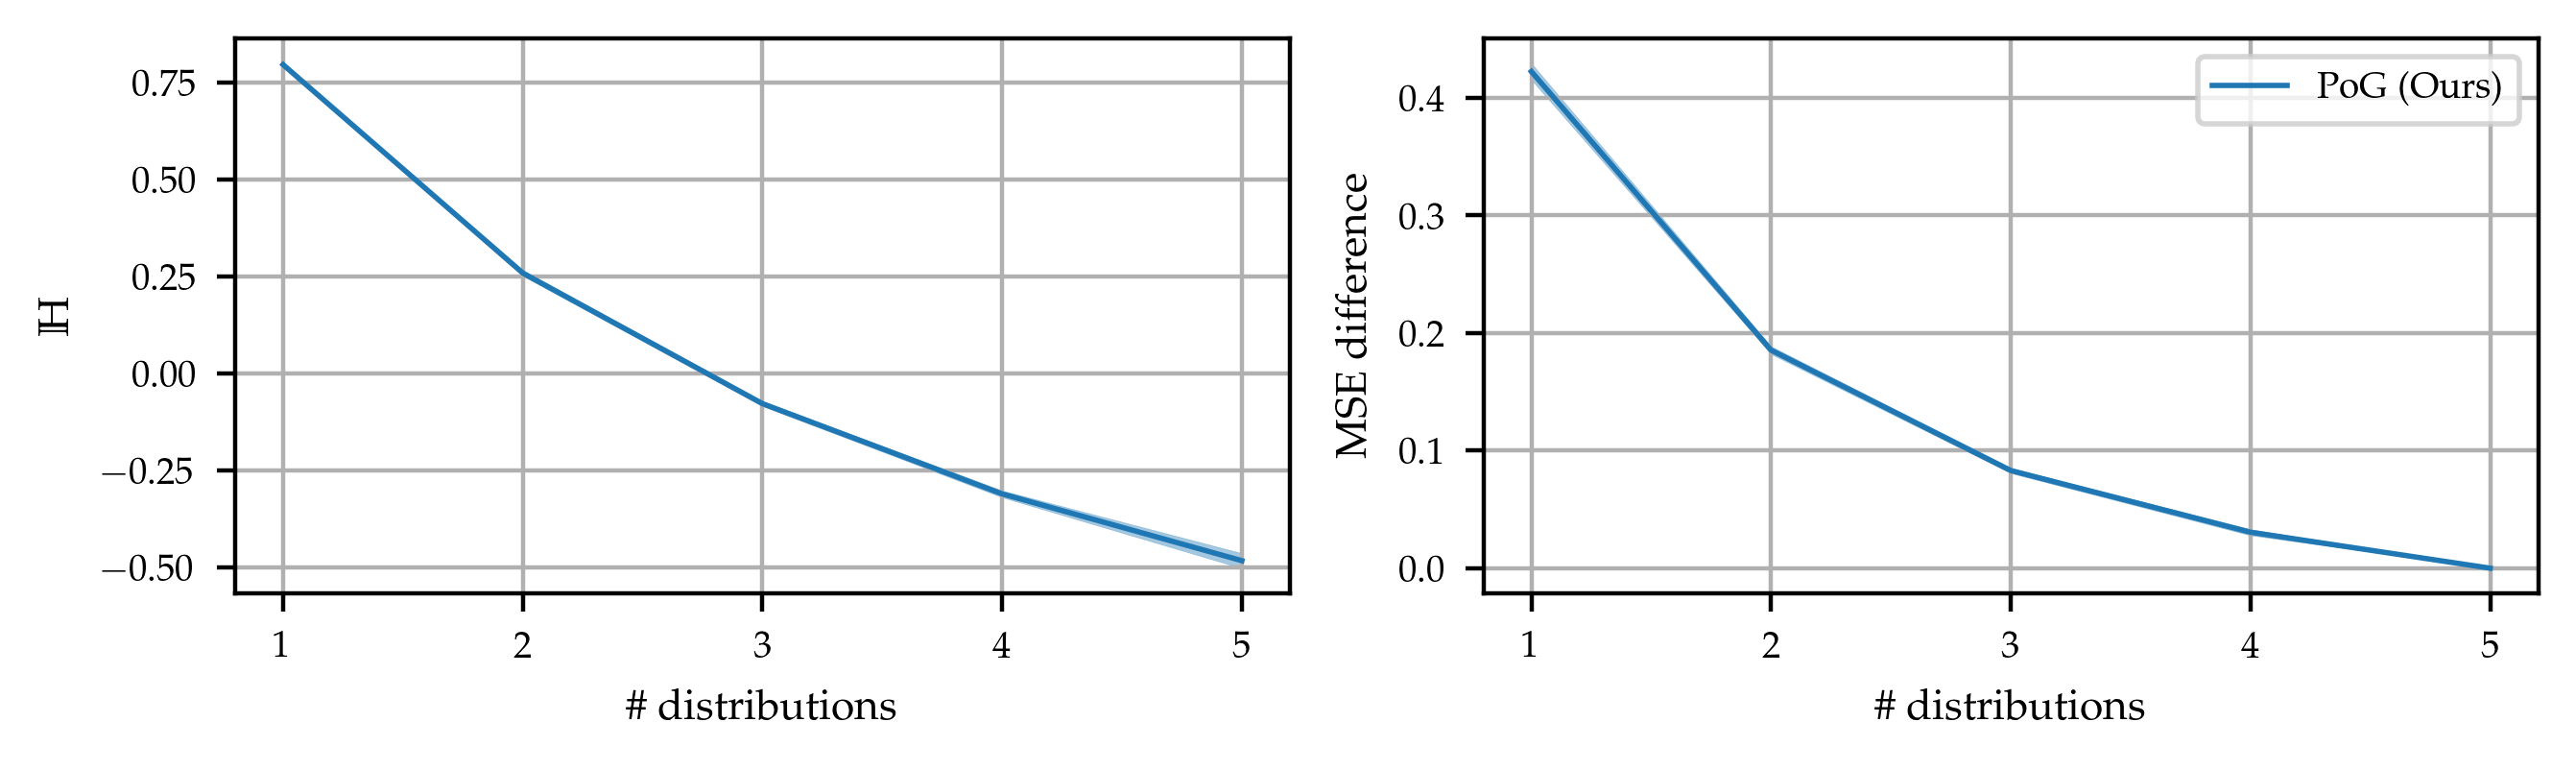

In [131]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(text_width, text_width/3.3), dpi=dpi, sharey=False, sharex=True, layout='tight')

H_df = agg_df['H'].reset_index()
x = H_df['n_members']
y = H_df['mean']
y_err = H_df['std_err']

axs[0].plot(x, y, c='C0', lw=1.)
axs[0].fill_between(x, y - y_err, y + y_err, color='C0', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('$\mathbb{H}$')
axs[0].set_xlabel('$\#$ distributions')
axs[0].set_xticks([1, 2, 3, 4, 5])

mse_df = agg_df['mse_diff'].reset_index()
x = mse_df['n_members']
y = mse_df['mean']
y_err = mse_df['std_err']

axs[1].plot(x, y, c='C0', lw=1., label='PoG (Ours)')
axs[1].fill_between(x, y - y_err, y + y_err, color='C0', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('MSE difference')
axs[1].set_xlabel('$\#$ distributions')
axs[1].set_xticks([1, 2, 3, 4, 5])
axs[1].legend()

plt.savefig('toy_entropy_mse_evolution.pdf', dpi=dpi, bbox_inches='tight')